In [147]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

Dateset considered here is the "Computer Hardware
Performance Metrics and Specifications of Historical Computer Hardware" from kaggle.

Dataset Overview

Characteristics:

* Number of Instances: 209
* Number of Features: 10
* Missing Values: No

Description:
This dataset includes information about computer hardware with a focus on performance metrics.

Variables:

VendorName

    Role: Feature
    Type: Categorical
    Description: Names of the vendors (e.g., adviser, amdahl, apollo, etc.)
    Missing Values: No
ModelName

    Role: Feature
    Type: Categorical
    Description: Unique symbols for model names
    Missing Values: No
MYCT

    Role: Feature
    Type: Integer
    Description: Machine cycle time (in nanoseconds)
    Missing Values: No
MMIN

    Role: Feature
    Type: Integer
    Description: Minimum main memory (in kilobytes)
    Missing Values: No
MMAX

    Role: Feature
    Type: Integer
    Description: Maximum main memory (in kilobytes)
    Missing Values: No
CACH

    Role: Feature
    Type: Integer
    Description: Cache memory (in kilobytes)
    Missing Values: No
CHMIN

    Role: Feature
    Type: Integer
    Description: Minimum channels (in units)
    Missing Values: No
CHMAX

    Role: Feature
    Type: Integer
    Description: Maximum channels (in units)
    Missing Values: No
    PRP
    
    Role: Feature
    Type: Integer
    Description: Published relative performance
    Missing Values: No
ERP

    Role: Feature
    Type: Integer
    Description: Estimated relative performance from the original article
    Missing Values: No

Therefore, the reason behind choosing Cache Memory as the predictor is that it often scales nonlinearly (power-law) with performance. We may expect weight to increase disproportionately as Cache Memory increases, hence nonlinear curve.


The goal here is to use nonparametric smoothing to explore and model this relationship.

In [148]:
df= pd.read_csv("Comp Hardware Performance data.txt",sep=',',header=None)
df.columns = ['vendor name','Model Name','MYCT','MMIN','MMAX','CACH','CHMIN','CHMAX','PRP','ERP']

In [149]:
df

,vendor name,Model Name,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP,ERP
0,adviser,32/60,125,256,6000,256,16,128,198,199
1,amdahl,470v/7,29,8000,32000,32,8,32,269,253
2,amdahl,470v/7a,29,8000,32000,32,8,32,220,253
3,amdahl,470v/7b,29,8000,32000,32,8,32,172,253
4,amdahl,470v/7c,29,8000,16000,32,8,16,132,132
...,...,...,...,...,...,...,...,...,...,...
204,sperry,80/8,124,1000,8000,0,1,8,42,37
205,sperry,90/80-model-3,98,1000,8000,32,2,8,46,50
206,sratus,32,125,2000,8000,0,2,14,52,41
207,wang,vs-100,480,512,8000,32,0,0,67,47


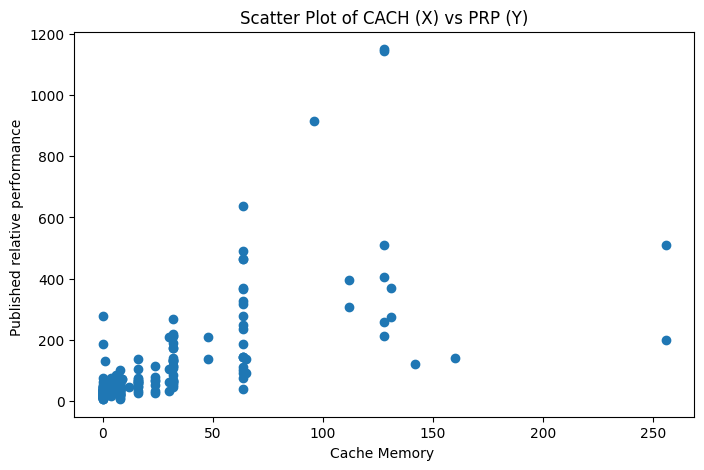

In [150]:
# Selecting the predictor and response
X = df[['CACH']].values  # Predictor
Y = df[['PRP']].values   # Response

# Scatter plot btw X and Y.
plt.figure(figsize=(8, 5))
plt.scatter(X, Y)
plt.title('Scatter Plot of CACH (X) vs PRP (Y)')
plt.xlabel('Cache Memory '); plt.ylabel('Published relative performance ')
plt.show()

The scatter plot shows that there seems to have an exponential relationship between X and Y.

In [151]:
# Checking for missing values
print("Missing values in dataset:")
print(df[["PRP",'CACH']].isnull().sum())

Missing values in dataset:
PRP     0
CACH    0
dtype: int64


There is no missing enteries in the dataset, so none of the rows get dropped from the subset (X and Y).

In [152]:
# Checking for outliers using z-score on Weight ---
z_scores = np.abs((Y - np.mean(Y)) / np.std(Y))
df_clean = df[z_scores < 3]  # Removing extreme outliers

Outlier detection: One common technique for detecting outliers is Z score. It is a statistical measurement that describes how far a data point is from the mean, expressed in terms of standard deviations. It helps us to identify if a data point is relatively higher or lower than the mean and how far it deviates from the average value. Commonly, data points with a Z-score greater than 3 or less than -3 are considered outliers as they lie more than 3 standard deviations away from the mean.

In [154]:
df_clean = df_clean[df_clean["CACH"]<=140]
df_clean = df_clean[~((df_clean["CACH"] <= 5) & (df_clean["PRP"] > 125))]

In [166]:
print("Before outlier detection : ", df.shape); print("After outlier detection : ",df_clean.shape)

Before outlier detection :  (209, 10)
After outlier detection :  (198, 10)


 So eleven points (potential outliers) got eliminated.

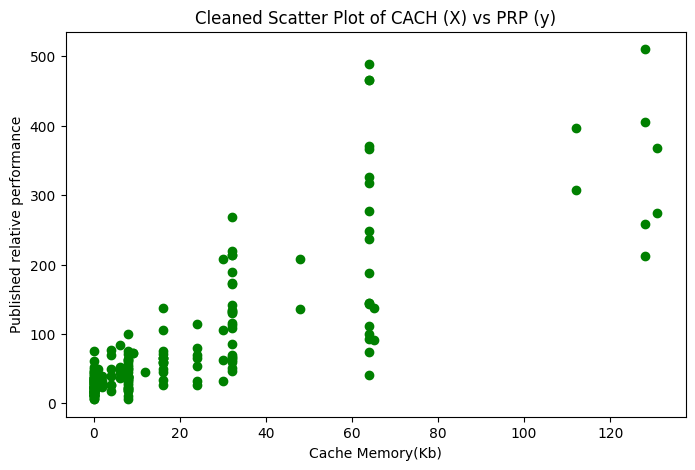

In [155]:
# Scatter plot after removing outliers
plt.figure(figsize=(8, 5))
plt.scatter(df_clean['CACH'], df_clean['PRP'], color='green')
plt.title('Cleaned Scatter Plot of CACH (X) vs PRP (y)')
plt.xlabel('Cache Memory(Kb)')
plt.ylabel('Published relative performance')
plt.show()

From the cleaned scatter plot, there seems to be a curved and increasing trend, as the Cache Memory(Kb) increases Performance also seems to increase in an exponential manner.

Here instead of a parametric regression that would impose a specific functional form, we adopt non parametric approaches such as KNN smoother, Kernel smoother, LOESS, that would be completely based on the local structure of the data. But for comparison purpose, we will fit a parametric regression and draw a comparison with the rest of the non-parametric techniques.

In [156]:
# cleaned data
X_clean = df_clean['CACH'].values
Y_clean = df_clean['PRP'].values

# Train/Test Split (80/20)
X_train, X_test, Y_train, Y_test = train_test_split(X_clean, Y_clean, test_size=0.2, random_state=0)


In [157]:
print(f"X_train : {X_train.shape}, Y_train : {Y_train.shape}, X_test : {X_test.shape}, Y_test : {Y_test.shape}")

X_train : (158,), Y_train : (158,), X_test : (40,), Y_test : (40,)


In [158]:
# Implementation of the non parametric smoothing techniques

# KNN Smoother

def knn_predict(x, k, x_train, y_train):
    dist = np.abs(x_train - x)
    nearest_ind = np.argsort(dist)[:k]
    return np.mean(y_train[nearest_ind])

def knn_smoother(k, x_train, y_train, x_val, y_val):
    y_pred = []
    for x in x_val:
        y_pred.append(knn_predict(x, k, x_train, y_train))
    y_pred = np.array(y_pred)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    return mse, mae

# Kernel Smoother (Gaussian Kernel)

def gaussian_kernel(u):
    return 1 / np.sqrt(2 * np.pi) * np.exp(-0.5 * u**2)

def kernel_predict(xo, x_train, y_train, h):
    w = gaussian_kernel((xo - x_train) / h)
    denom = np.sum(w)
    if denom == 0 or np.isnan(denom):
        return np.nan   # No weights → undefined → mark as NaN
    return np.sum(w * y_train) / (denom + 1e-12)

def kernel_smoother(bandwidth, x_train, y_train, x_val, y_val):
    x_val = np.clip(x_val, np.min(x_train), np.max(x_train))
    y_pred = []

    for x0 in x_val:
        w = np.exp(-((x_train - x0) ** 2) / (2 * bandwidth ** 2))
        denom = np.sum(w)
        if denom == 0:
            y_pred.append(np.nan)
        else:
            y_pred.append(np.sum(w * y_train) / denom)

    y_pred = np.array(y_pred)
    valid_mask = ~np.isnan(y_pred)
    mse = mean_squared_error(y_val[valid_mask], y_pred[valid_mask])
    mae = mean_absolute_error(y_val[valid_mask], y_pred[valid_mask])
    return mse, mae
# LOESS Smoother

def loess_smoother(frac, x_train, y_train, x_val, y_val):
    # Flatten y_train to make it a 1D vector for the lowess function
    y_pred = lowess(y_train, x_train, frac=frac, return_sorted=False, xvals=x_val)
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    return mse, mae

The Smoothing techniques adopted here are KNN smoother, Kernel smoother (gaussian kernel), LOWESS.

In [159]:
# Performing Cross-validation
def cross_validate_smoother(param_values, smoother_name):
  n_splits = 4
  kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
  mse_list = []
  mae_list = []

  for param in param_values:
      mse_folds = []
      mae_folds = []

      for train_idx, val_idx in kf.split(X_train):
          X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
          Y_train_fold, Y_val_fold = Y_train[train_idx], Y_train[val_idx]

          if smoother_name == "knn":
              mse, mae = knn_smoother(param, X_train_fold, Y_train_fold, X_val_fold, Y_val_fold)
          elif smoother_name == "kernel":
              mse, mae = kernel_smoother(param, X_train_fold, Y_train_fold, X_val_fold, Y_val_fold)
          elif smoother_name == "loess":
              mse, mae = loess_smoother(param, X_train_fold, Y_train_fold, X_val_fold, Y_val_fold)

          mse_folds.append(mse)
          mae_folds.append(mae)

      mse_list.append(np.mean(mse_folds))
      mae_list.append(np.mean(mae_folds))

  return mse_list, mae_list


If we choose a very small number of folds,
the training sets are smaller. Models trained on smaller datasets tend to be less representative of the true model that would be learned from the entire dataset, leading to higher bias. Smaller training set sizes across the folds can result in models that are less stable and more sensitive to the specific data points in each fold, leading to more variability in the performance estimates across different folds. It results in a lower computational cost because the model is trained fewer times.

And if we choose very large number of folds, each model is trained on a larger portion of the data. This leads to a more accurate and less biased estimate of the model's performance because the training data for each fold is more representative of the full dataset. When the number of folds increases, the validation set for each fold becomes smaller. This can cause a higher variance in the model's performance across the different folds. It results in a significant increase in the computational cost and time.

We have 158 observations in the training set, choosing 4-fold cross validation will be suitable here as approximately 39 observations would be there in each fold, which provides a good trade-off between bias and variance and not results in a very high computational cost and time.

So, we choose 4 folds for cross-validation.

No. of hyperparameters in knn: 24 No. of hyperparameters in kernel: 24 No. of hyperparameters in loess: 24


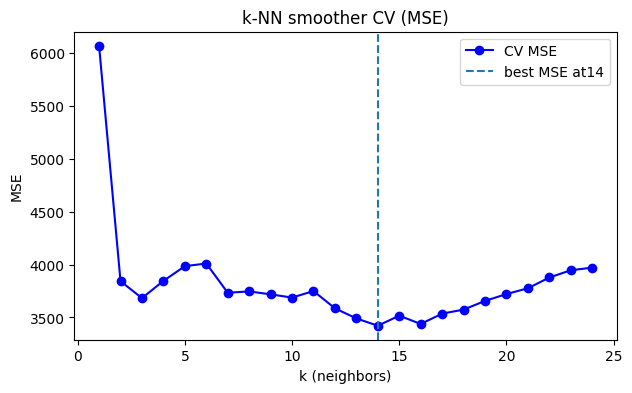

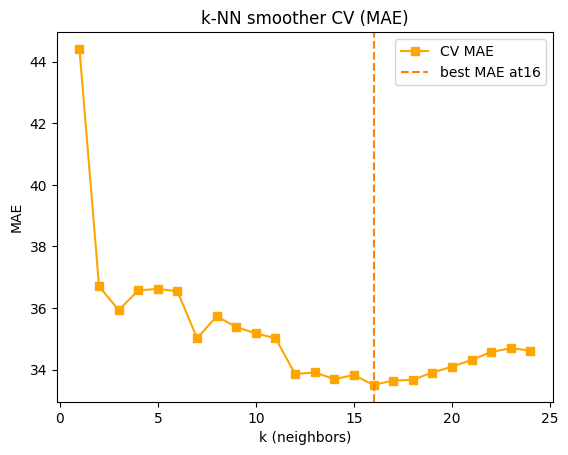

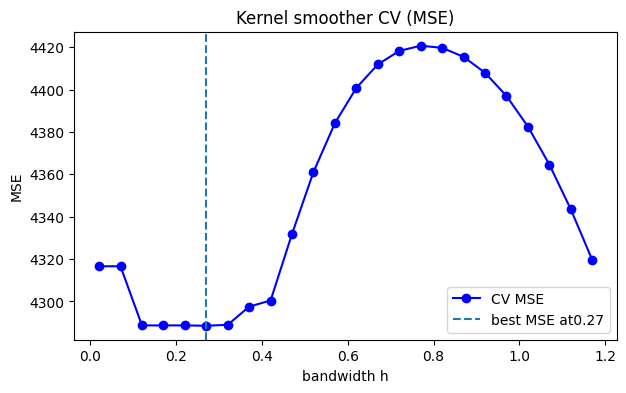

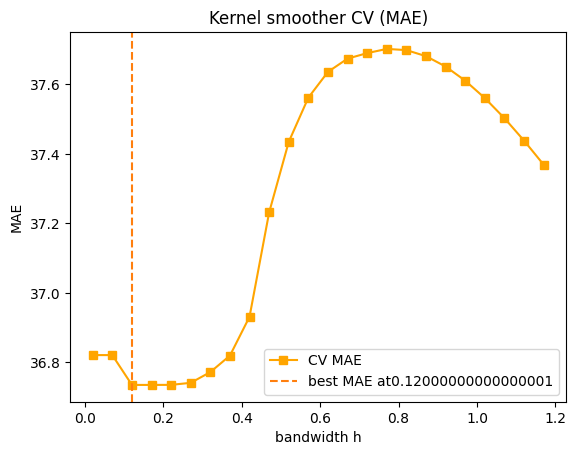

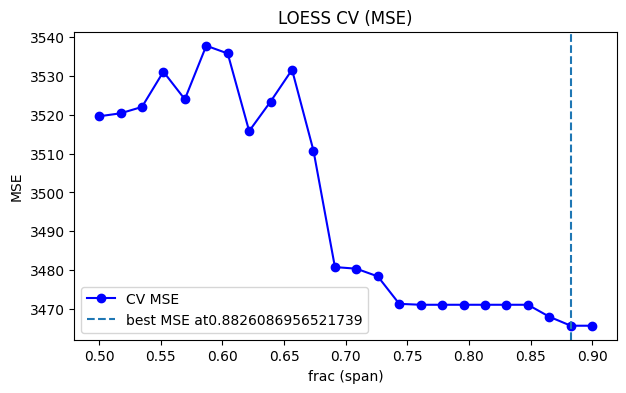

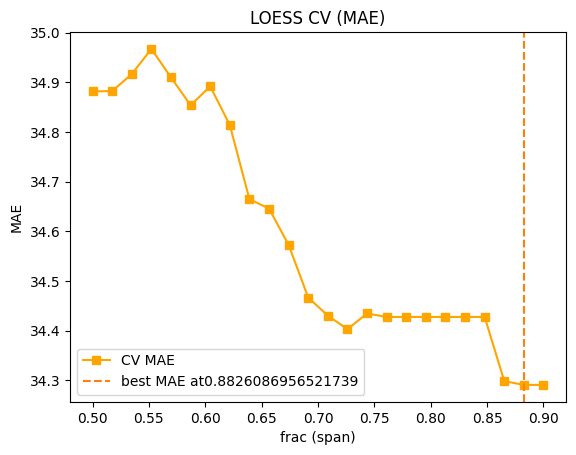


Selected best hyperparameters by CV MSE:
k-NN k = 14
Kernel h = 0.27
LOESS frac = 0.8826086956521739


In [160]:
# A grid of values for the hyperparameters
knn_grid = list(range(1, 25, 1))
kernel_grid = list(np.arange(0.02,1.2,0.05))
loess_grid = list(np.linspace(0.5, 0.9, len(kernel_grid)))

print("No. of hyperparameters in knn:", len(knn_grid),
      "No. of hyperparameters in kernel:", len(kernel_grid), "No. of hyperparameters in loess:", len(loess_grid))

# Running CV for each smoothing technique
knn_mse, knn_mae = cross_validate_smoother(knn_grid, "knn")

kernel_mse, kernel_mae = cross_validate_smoother(kernel_grid, "kernel")

loess_mse, loess_mae = cross_validate_smoother(loess_grid, "loess")

def plot_cv(param_grid, mse_vals, mae_vals, xlabel, title_mse, title_mae):
    plt.figure(figsize=(7,4))
    plt.plot(param_grid, mse_vals, marker='o', c = "blue", label='CV MSE')
    # mark minima
    idx_min_mse = np.argmin(mse_vals)
    idx_min_mae = np.argmin(mae_vals)
    p_mse = param_grid[idx_min_mse]
    p_mae = param_grid[idx_min_mae]
    cv_mse = mse_vals[idx_min_mse]
    plt.axvline(p_mse, color='C0', linestyle='--', label=f'best MSE at{p_mse}')
    plt.xlabel(xlabel)
    plt.ylabel("MSE")
    plt.title(title_mse)
    plt.legend()
    plt.show()
    plt.plot(param_grid, mae_vals, marker='s', c = "orange", label='CV MAE')
    plt.axvline(p_mae, color='C1', linestyle='--', label=f'best MAE at{p_mae}')
    plt.xlabel(xlabel)
    plt.ylabel("MAE")
    plt.title(title_mae)
    plt.legend()
    plt.show()
    return p_mse, p_mae, cv_mse

# Ploting the CV curves and extracting the optimal hyperparameters
best_knn_mse, best_knn_mae, knn_cv_mse = plot_cv(knn_grid, knn_mse, knn_mae, 'k (neighbors)', 'k-NN smoother CV (MSE)', 'k-NN smoother CV (MAE)')
best_kernel_mse, best_kernel_mae, kernel_cv_mse = plot_cv(kernel_grid, kernel_mse, kernel_mae, 'bandwidth h', 'Kernel smoother CV (MSE)', 'Kernel smoother CV (MAE)')
best_loess_mse, best_loess_mae, loess_cv_mse = plot_cv(loess_grid, loess_mse, loess_mae, 'frac (span)', 'LOESS CV (MSE)', 'LOESS CV (MAE)')

print("\nSelected best hyperparameters by CV MSE:")
print("k-NN k =", best_knn_mse)
print("Kernel h =", best_kernel_mse)
print("LOESS frac =", best_loess_mse)

For KNN smoother, hyperparameter is the number of neighbours (K), if we increase the number of neighbours, so more data points will be included in  the neighbourhood in order to obtain the estimated value of the function at a particular point. The estimator will be more stabilized, variance will reduce but bias will increase since points which are farther away are considered in the neighbourhood of the estimation point which might not reflect the local behaviour at that point, and hence introduces bias.

For Kernel smoother, the hyperparameter is the bandwidth (h), it defines the width of the neighbourhood. If we increase h, then the widht of the neighbourhood will increase, variance will decrease and bias will increase.

For LOWESS, the hyperparamter is the frac. It specifies the fraction of data points used to fit the local regression for each estimate. If we increase frac, then more data points will be considered in the local fit, resulting in lesser variance and increased bias.

Here, we have considered a grid of values for each of the smoothing technique to perform cross validation:

 - KNN : 1,2,3,....25
 - Kernel : 0.02, 0.07, 0.12,...1.2
 - LOESS : 0.5 to 0.9 of size 24

 This grid of values have been decided by performing experimentations.

Here, we have chosen, MSE (mean squared error) and MAE (mean absolute error) as the error metrics. MSE penalizes larger errors heavily and is sensitive to outliers; MAE is robust and easier to interpret.

Here, we have chosen MSE to choose the optimal hyperparamters.

In all three cases, the cv error (MSE and MAE) decreases as the hyperparameter values increases, attains a minimum value and then again increases. The value of the hyperparameter for which the CV MSE attains the lowest value is the optimal choice of the hyperparameter.

In [161]:
pd.DataFrame({'KNN - K':knn_grid, 'KNN - MSE': knn_mse, 'KNN - MAE': knn_mae, 'Kernel- h':kernel_grid, 'Kernel - MSE': kernel_mse, 'Kernel - MAE': kernel_mae, 'LOESS - frac':loess_grid, 'LOESS - MSE': loess_mse, 'LOESS - MAE': loess_mae}).head()

,KNN - K,KNN - MSE,KNN - MAE,Kernel- h,Kernel - MSE,Kernel - MAE,LOESS - frac,LOESS - MSE,LOESS - MAE
0,1,6072.145513,44.413462,0.02,4316.612620,36.821051,0.500000,3519.597661,34.881636
1,2,3843.345353,36.705609,0.07,4316.612620,36.821051,0.517391,3520.364128,34.882252
2,3,3682.658102,35.935737,0.12,4288.713366,36.735218,0.534783,3522.000844,34.916605
3,4,3845.507492,36.572276,0.17,4288.713361,36.735218,0.552174,3531.076211,34.967151
4,5,3985.418231,36.623654,0.22,4288.707664,36.735410,0.569565,3523.977374,34.909694


Optimal choice of hyperparameter:
 - KNN smoothing(K) = 14
 - Kernel smoothing (h) = 0.27
 - LOWESS (frac) = 0.8826086956521739

Using the optimal choice of the hyperparameters, we fit the final model (smoothing techniques) on the entire train set, and obtain the Test MSE and Test MAE on the test set to conclude which model performs best (generalizes well on the unseen observations).

In [162]:
# Fiting the final models on full training data using the optimal hyperparameters based on MSE

def fit_knn_model(xk, k, Xtrain, ytrain):
  xk = np.array(xk)
  preds = []
  for x in xk:
      preds.append(knn_predict(x, k, Xtrain, ytrain))
  return np.array(preds)

def fit_kernel_model(xk, h, Xtrain, ytrain):
  xk = np.array(xk)
  preds = []
  for x in xk:
      preds.append(kernel_predict(x, Xtrain, ytrain, h))
  return np.array(preds)

def fit_loess_model(xk, frac, Xtrain, ytrain):
  xk = np.array(xk)
  return lowess(ytrain, Xtrain, frac=frac, return_sorted=False, xvals=xk)

#prediction on the test set
y_pred_knn = fit_knn_model(X_test, best_knn_mse, X_train, Y_train)
y_pred_kernel = fit_kernel_model(X_test, best_kernel_mse, X_train, Y_train)
y_pred_kernel = np.nan_to_num(y_pred_kernel, nan=np.mean(Y_train))
y_pred_loess = fit_loess_model(X_test.flatten(), best_loess_mse, X_train.flatten(), Y_train.flatten())

# Evaluate on test set (based on MSE, MAE)
def eval_preds(y_true, y_pred):
    return mean_squared_error(y_true, y_pred), mean_absolute_error(y_true, y_pred)

knn_mse_test, knn_mae_test = eval_preds(Y_test, y_pred_knn)
kernel_mse_test, kernel_mae_test = eval_preds(Y_test, y_pred_kernel)
loess_mse_test, loess_mae_test = eval_preds(Y_test, y_pred_loess)

In [163]:
# Parametric Regression (Polynomial Regression of Degree 2)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

# Ensure X_train is a 2D array
X_train = X_train.reshape(-1,1)
Y_train = Y_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)
Y_test = Y_test.reshape(-1,1)

poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)

model = LinearRegression()
model.fit(X_poly, Y_train)

# Ensure X_test is also a 2D array before prediction
X_test_poly = poly.transform(X_test)
y_pred_quadreg = model.predict(X_test_poly)

quad_mse_test, quad_mae_test = eval_preds(Y_test, y_pred_quadreg)
quad_mse_test, quad_mae_test

(np.float64(3578.296968260067), np.float64(40.09521430169816))

In [164]:

# Final results table for comparision between the models
results = pd.DataFrame([
    {'Method':'KNN', 'Optimal Hyperparameter':best_knn_mse, 'CV MSE':knn_cv_mse, 'Test_MSE':knn_mse_test, 'Test_MAE':knn_mae_test},
    {'Method':'Kernel', 'Optimal Hyperparameter':best_kernel_mse, 'CV MSE':kernel_cv_mse, 'Test_MSE':kernel_mse_test, 'Test_MAE':kernel_mae_test},
    {'Method':'LOESS', 'Optimal Hyperparameter':best_loess_mse, 'CV MSE':loess_cv_mse, 'Test_MSE':loess_mse_test, 'Test_MAE':loess_mae_test},
    {'Method':'Polynomial Regression (Deg = 2)', 'Optimal Hyperparameter':'-', 'CV MSE':'-', 'Test_MSE':quad_mse_test, 'Test_MAE':quad_mae_test}
])
results.head()

,Method,Optimal Hyperparameter,CV MSE,Test_MSE,Test_MAE
0,KNN,14,3421.472503,4361.632270,41.594643
1,Kernel,0.27,4288.563968,4074.476696,39.873677
2,LOESS,0.882609,3465.717821,3287.576145,37.157700
3,Polynomial Regression (Deg = 2),-,-,3578.296968,40.095214


Out of the three non-parametric techniques considered, LOESS performs the best. It was expected because LOESS typically produces a smoother, more flexible curve and offers built-in robustness to outliers, since it fits polynomial regression model locally to the weighted data points rather than just averaging. As a result it better captures the curvature of the data.

And in order to obtain a comparison, we also performed polynomial regression of degree 2 (Parametric), fitted globally. It outperforms LOESS in this scenario.

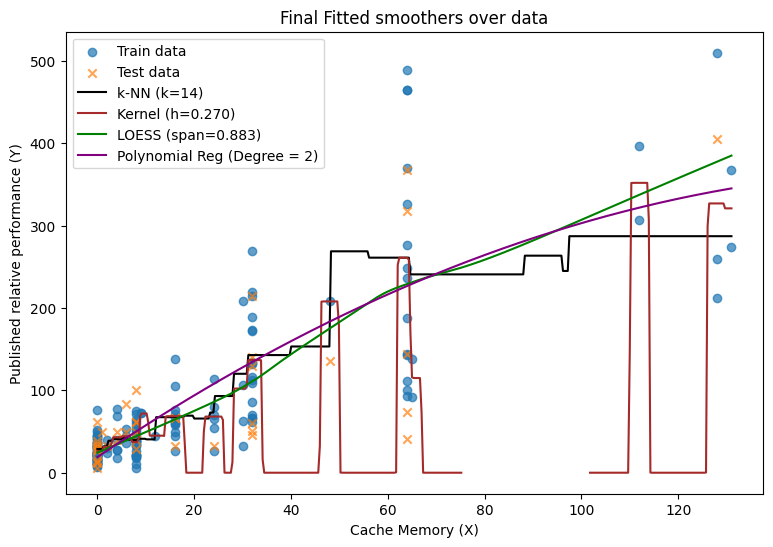

In [165]:
# Overlay fitted curves on the data
x_grid = np.linspace(X_train.min(), X_train.max(), 400).reshape(-1,1)
y_knn_grid = fit_knn_model(x_grid, best_knn_mse, X_train.flatten(), Y_train.flatten())
y_kernel_grid = fit_kernel_model(x_grid, best_kernel_mse, X_train.flatten(), Y_train.flatten())
y_loess_grid = fit_loess_model(x_grid.flatten(), best_loess_mse, X_train.flatten(), Y_train.flatten())
x_grid_poly = poly.transform(x_grid)
y_quadreg = model.predict(x_grid_poly)

plt.figure(figsize=(9,6))
plt.scatter(X_train, Y_train, marker='o', label='Train data', alpha = 0.7)
plt.scatter(X_test, Y_test, marker='x', label='Test data', alpha = 0.7)
plt.plot(x_grid, y_knn_grid, c = 'black', label=f'k-NN (k={best_knn_mse})', linewidth=1.5)
plt.plot(x_grid, y_kernel_grid, c = 'brown', label=f'Kernel (h={best_kernel_mse:.3f})', linewidth=1.5)
plt.plot(x_grid, y_loess_grid, c = 'green', label=f'LOESS (span={best_loess_mse:.3f})', linewidth=1.5)
plt.plot(x_grid, y_quadreg, c = 'purple', label = f'Polynomial Reg (Degree = 2)', linewidth = 1.5)
plt.xlabel('Cache Memory (X)')
plt.ylabel('Published relative performance (Y)')
plt.title('Final Fitted smoothers over data')
plt.legend()
plt.show()

From the visual inspection, LOESS (best performing model among non-parametric techniques) seems to appear smoothest. While Kernel Regression produces the most jagged curve.

 There can be situations where a different smoother can perform better as none of the methods are universally best, rather, each has distinct advantages depending on the specific data and context. Some of the scenarios are mentioned here:

 - If the true function contains abrupt local features, a more local smoother (smaller span / smaller bandwidth) could be better.
 - If the data is very noisy but the true function is simple, a coarser smoother or parametric model might outperform flexible smoothers (here, polynomial regression of degree = 2 (fitted globally) outperforms the best non-parametric smoothing technique).
 - If outliers are present, robust approaches (or MAE-focused tuning) may prefer a different smoother.


This project demonstrated that hyperparameters directly control the bias-variance tradeoff. Cross-validation is essential to choose hyperparameters that generalize well. Visual inspection of fitted curves alongside error metrics helps ensure the model is both accurate and interpretable.